In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from plotly.subplots import make_subplots
import pickle
import plotly.graph_objects as go
import plotly.express as px

import charset_normalizer
import fuzzywuzzy
from fuzzywuzzy import process
import os
import re
from dateutil import parser

import warnings

warnings.filterwarnings("ignore")
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

# Set random seed
seed = 42

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Character encoding


## Train set


In [3]:
train_df_name = []
train_encoding = []
train_path = []

dataset_folder = "dataset"
for file in os.listdir(dataset_folder):
    file_path = os.path.join(dataset_folder, file)
    train_path.append(file_path)
    # look at the first ten thousand bytes to guess the character encoding
    with open(file_path, "rb") as rawdata:
        result = charset_normalizer.detect(rawdata.read())
        train_encoding.append(result["encoding"])
    # check what the character encoding might be
    file_name = os.path.splitext(file)[0]
    train_df_name.append(file_name)
    print(f"{file_name}: {result}")


train_data_source = (tuple(train_df_name), tuple(train_encoding), tuple(train_path))
context = pd.read_csv(train_data_source[2][0], encoding=train_data_source[1][0])
mobile_plan_attr = pd.read_csv(
    train_data_source[2][1], encoding=train_data_source[1][1], delimiter=";"
)
mobile_plan_user = pd.read_csv(train_data_source[2][2], encoding=train_data_source[1][2])
user = pd.read_csv(train_data_source[2][3], encoding=train_data_source[1][3])


train_set = [context, mobile_plan_attr, mobile_plan_user, user]

context: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
mobile_plan_attr: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
mobile_plan_user: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
user: {'encoding': 'utf-8', 'language': 'English', 'confidence': 1.0}


## Test set


In [4]:
test_df_name = []
test_encoding = []
test_path = []

dataset_folder = "test"
for file in os.listdir(dataset_folder):
    file_path = os.path.join(dataset_folder, file)
    test_path.append(file_path)
    # look at the first ten thousand bytes to guess the character encoding
    with open(file_path, "rb") as rawdata:
        result = charset_normalizer.detect(rawdata.read())
        test_encoding.append(result["encoding"])
    # check what the character encoding might be
    file_name = os.path.splitext(file)[0]
    test_df_name.append(file_name)
    print(f"{file_name}: {result}")

test_data_source = (tuple(test_df_name), tuple(test_encoding), tuple(test_path))
context_test = pd.read_csv(test_data_source[2][0], encoding=test_data_source[1][0])
mobile_plan_attr_test = pd.read_csv(
    test_data_source[2][1], encoding=test_data_source[1][1], delimiter=";"
)
mobile_plan_user_test = pd.read_csv(test_data_source[2][2], encoding=test_data_source[1][2])
user_test = pd.read_csv(test_data_source[2][3], encoding=test_data_source[1][3])


test_set = [context_test, mobile_plan_attr_test, mobile_plan_user_test, user_test]

context: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
mobile_plan_attr: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
mobile_plan_user: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
user: {'encoding': 'utf-8', 'language': 'Spanish', 'confidence': 1.0}


# Cleaning

## Missing values check


In [5]:
print('*'*10 + ' Train set ' + '*'*10)
for x in train_set:
  print('-----------------')
  print(x.isna().sum())
print('')

print('*'*10 + ' Test set ' + '*'*10)
for x in test_set:
  print('-----------------')
  print(x.isna().sum())

********** Train set **********
-----------------
id              0
purpose         0
go_with         0
weather         0
time            0
viettel_no_0    0
viettel_no_1    0
viettel_no_2    0
to_hanoi        0
to_other        0
score           0
direction       0
dtype: int64
-----------------
mobile_plan    0
description    0
price          0
duration       0
dtype: int64
-----------------
id                0
mobile_plan    2715
accept         2721
dtype: int64
-----------------
id                      0
name                    0
gender                  0
age                     0
education            4003
profession              0
income                  0
living_with             0
nation                  0
phone                   0
job                     0
fb_freq                 0
yt_freq                 0
insta_freq              0
use_less_than_2GB       0
use_2GB_to_4GB          0
dtype: int64

********** Test set **********
-----------------
id              0
purpose         

In [6]:
mobile_plan_user = mobile_plan_user.dropna(subset=['mobile_plan', 'accept'])

mobile_plan_user_test = mobile_plan_user_test.dropna(subset=['coupon_id', 'accept'])

## Duplicate


In [7]:
print(user['id'].duplicated().sum())

print(user_test['id'].duplicated().sum())

0
0


In [8]:
print(context['id'].duplicated().sum())

print(context_test['id'].duplicated().sum())

0
0


In [9]:
print(mobile_plan_user[mobile_plan_user.duplicated(subset=['id'])].sort_values('id').head())

print('')

print(mobile_plan_user_test[mobile_plan_user_test.duplicated(subset=['id'])].sort_values('id').head())

           id  mobile_plan  accept
18023  1000.0  SOCIALMEDIA     0.0
18022  1000.0     DATACALL     0.0
18021  1000.0   DATASILVER     0.0
18162  1001.0  SOCIALMEDIA     0.0
18163  1001.0     DATACALL     0.0

          id    coupon_id  accept
1155  1064.0   DATASILVER     0.0
1121  1331.0  SOCIALMEDIA     1.0
1120  1331.0  SOCIALMEDIA     1.0
1310  1625.0  SOCIALMEDIA     0.0
1332  1733.0   DATASILVER     0.0


## Context


In [10]:
context.sample(5)

,id,purpose,go_with,weather,time,viettel_no_0,viettel_no_1,viettel_no_2,to_hanoi,to_other,score,direction
8451,10272,Visit,%Alone,%?!Sunny,16:00,1,0,0,1,0,0,1
3262,13746,Travel,Family,Sunny,5 PM,1,0,0,0,1,11,0
2490,13472,Travel,Fri&end(s),Sunny,14:00,1,0,0,0,1,0,0
6813,16641,Visit,%A&?lone,&Sunny,5PM,1,0,0,1,0,8,1
6991,18979,Travel,Friend(s),!Su!nny,11:00,1,1,0,0,1,0,0


In [11]:
context_test.sample(5)

,id,purpose,go_with,weather,time,viettel_no_0,viettel_no_1,viettel_no_2,to_hanoi,to_other,score,direction
494,18229,Work,Alone,~%?S&unny,6:00,1,0,0,1,0,0,1
906,3379,Work,A &lone,Ra!&iny,6:00,1,1,1,0,1,5,0
52,18165,Travel,Friend(s),Sunny,8:00,1,0,0,0,1,0,0
139,11993,Work,%&!A~lone,Sunny,7AM,1,0,0,1,0,0,1
344,4446,Work,?Alone,!Sunny,6:00,1,1,1,0,1,0,0


### Go with and weather


In [12]:
for x in ["go_with", "weather"]:
    # Eliminate special characters and white spaces
    context[x] = context[x].apply(lambda x: re.sub(r"[^a-zA-Z\s]", "", x))
    context_test[x] = context_test[x].apply(lambda x: re.sub(r"[^a-zA-Z\s]", "", x))

    # Lowercase all words
    context[x] = context[x].str.lower()
    context_test[x] = context_test[x].str.lower()

    print(context[x].unique())
    print('')
    print(context_test[x].unique())

['alone' 'friends' 'fa mily' 'family' 'fami ly' 'a l one' 'fr iends'
 ' alone' 'a lone' '  alone' ' friends' 'f riends' 'f rie nds' 'frie nds'
 'frien ds' 'f amily' ' family' 'alo ne' 'friend s' 'al one' 'fri ends'
 ' a lone' ' fri ends' 'f riend s' 'alon e' 'frien  ds' ' fri e nds'
 'friends ' 'a  lone' 'fa  mily' 'al  one' '   alone' 'fri e nds'
 ' al one' 'fam ily' '  family' 'f rien ds' '  a lone' ' f amily'
 'frie   nds' 'fri en ds' 'f a mily' ' frie nds' 'f  amily' 'fr  iends'
 ' fa mily' 'famil y' ' fr iends' 'fr ie nds' 'fr ien ds' ' f  amily'
 'fam  ily' ' frien ds' 'frie nd s' 'frie n ds' ' friend s' 'frie  nds'
 'fr i ends' 'fri  ends' 'f ri ends' ' a  lone' ' alo ne' 'friend  s'
 'a   lone' '  friends' '   friends' ' fam ily' 'f r iends' 'alo  ne'
 '  a  lone' ' fa  mily' 'f r  iends' 'f  riends' ' frie  nds' 'fri end s'
 ' fami ly' 'f rie  nds' ' f riends' ' al  one' 'f a  mily' ' fa m ily'
 '    alone' 'f  ri ends' 'a lo ne' 'frien d s' 'f am ily' '  f riends'
 '   family

In [13]:
# List of possible values for the column 'go_with'
choices = ["alone", "friend(s)", "family"]


# Apply the fuzzy matching to the column 'go_with'
def correct_name(name):
    return process.extractOne(name, choices)[0]


context["go_with"] = context["go_with"].apply(correct_name)
context_test["go_with"] = context_test["go_with"].apply(correct_name)

### Time


In [14]:
# Eliminate white spaces
context["time"] = context["time"].str.replace(r"\s+", "", regex=True)
context_test["time"] = context_test["time"].str.replace(r"\s+", "", regex=True)


# Function to convert time to 24-hour format
def convert_to_24hr_format(time_str):
    # Use dateutil.parser to parse the time string
    return parser.parse(time_str).strftime("%H:%M")


# Apply the function to the column 'time'
context["time"] = context["time"].apply(convert_to_24hr_format)
context["time"] = pd.to_datetime(context["time"], format="%H:%M")

context_test["time"] = context_test["time"].apply(convert_to_24hr_format)
context_test["time"] = pd.to_datetime(context_test["time"], format="%H:%M")

def time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

context['hour'] = pd.to_datetime(context['time']).dt.hour
context['time_of_day'] = context['hour'].apply(time_of_day)

context_test['hour'] = pd.to_datetime(context_test['time']).dt.hour
context_test['time_of_day'] = context_test['hour'].apply(time_of_day)

context = context.drop(columns=['time', 'hour'])
context_test = context_test.drop(columns=['time', 'hour'])

### Purpose


In [15]:
context["purpose"] = context["purpose"].str.strip()
context["purpose"] = context["purpose"].str.lower()

context_test["purpose"] = context_test["purpose"].str.strip()
context_test["purpose"] = context_test["purpose"].str.lower()

In [16]:
print(context.purpose.unique())
print(context_test.purpose.unique())

['travel' 'visit' 'work']
['travel' 'visit' 'work']


In [17]:
context["purpose"] = context["purpose"].replace('travel', 'visit')
context_test["purpose"] = context_test["purpose"].replace('travel', 'visit')

### to_hanoi, to_other, direction


In [18]:
context = context.drop(axis=1, columns=["to_hanoi", "to_other"])
context_test = context_test.drop(axis=1, columns=["to_hanoi", "to_other"])

### viettel_no


In [19]:
for x in ['viettel_no_0', 'viettel_no_1', 'viettel_no_2']:
  context[x] = context[x].apply(lambda y: True if y == 1 else False)
  context_test[x] = context_test[x].apply(lambda y: True if y == 1 else False)

### direction


In [20]:
context['direction'] = context['direction'].apply(lambda x: True if x == 1 else False)

context_test['direction'] = context_test['direction'].apply(lambda x: True if x == 1 else False)

In [21]:
context.sample(5)

,id,purpose,go_with,weather,viettel_no_0,viettel_no_1,viettel_no_2,score,direction,time_of_day
969,1428,work,alone,sunny,True,True,False,0,False,morning
5647,16299,visit,alone,sunny,True,False,False,23,True,evening
404,10082,visit,family,sunny,True,False,False,20,False,evening
2628,13097,visit,friend(s),sunny,True,False,False,0,False,morning
1239,18767,visit,friend(s),sunny,True,True,False,0,False,night


In [22]:
context_test.sample(5)

,id,purpose,go_with,weather,viettel_no_0,viettel_no_1,viettel_no_2,score,direction,time_of_day
330,4494,visit,friend(s),sunny,True,True,False,0,False,evening
609,11355,visit,alone,sunny,True,False,False,0,False,afternoon
1063,5700,visit,friend(s),sunny,True,False,False,0,False,morning
57,14390,visit,family,sunny,True,False,False,0,False,afternoon
128,12773,visit,friend(s),sunny,True,True,False,0,False,afternoon


## User


In [23]:
user.sample(5)

,id,name,gender,age,education,profession,income,living_with,nation,phone,job,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB
4142,8683,Hunter Phelps,Male,23,Bachelor,Unemployed,9137500000 VND,S i ngle_0,US,(614)743-6875x2805,Insurance risk surveyor,0,7,1,0,1
8655,3396,吕鑫,Female,54,Bachelor,Unemployed,35000000 VND,S in gle_0,CHINA,18955388855,公务员,0,0,1,0,0
53,7708,Warren Bowen,Male,21,Associate,Student,617500000 VND,Sin gle_0,US,+1-891-845-9699x503,Plant breeder/geneticist,3,0,3,0,2
9987,7801,Anthony Spencer,Other,44,Masters,Business & Financial,2310000000 VND,M arried_3,ENGLAND,(275)381-3015x34015,Armed forces technical officer,0,1,7,2,0
6477,17595,Wendy Williams,Female,35,Bachelor,Education&Training&Library,37300$,Sin g le_0,US,635.457.5910,Field seismologist,1,8,0,8,1


In [24]:
user_test.sample(5)

,id,name,gender,age,education,profession,income,living_with,nation,phone,job,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB
661,9819,Beatrix Kensy,Female,54,Associate,Legal,275200$,Married_1,DENMARK,06985439564,Mathematiker,0,0,15,8,2
77,5744,Cindy Finke,Female,32,Bachelor,Legal,453100$,U nmar ried_0,DENMARK,+49(0)5646 23234,Bäcker,0,0,1,2,1
463,5919,Vitória Santos,Female,59,Bachelor,Sales & Related,1352500000 VND,Married_0,BRAZIL,+55 (031) 6721 8141,Leiloeiro,1,5,0,2,1
309,9328,송현정,Female,68,Masters,Unemployed,8000$,S ingle_0,KOREA,017-603-7932,상/하수도 처리장치 조작원,0,22,1,1,1
467,13554,Luiza Pacheco,Female,38,Associate,Computer & Mathematical,24700$,Divorced_0,BRAZIL,51 0583 5407,Pizzaiolo,1,6,1,1,0


### living_with


In [25]:
# Eliminate white spaces
user["living_with"] = user["living_with"].str.strip()
user["living_with"] = user["living_with"].str.replace(r"\s+", "", regex=True)
user["living_with"] = user["living_with"].str.lower()

user_test["living_with"] = user_test["living_with"].str.strip()
user_test["living_with"] = user_test["living_with"].str.replace(r"\s+", "", regex=True)
user_test["living_with"] = user_test["living_with"].str.lower()

### nation


In [26]:
user["nation"] = user["nation"].str.strip()
user["nation"] = user["nation"].str.lower()

user["nation"] = user["nation"].replace("australia", "oceania")
user["nation"] = user["nation"].replace(["brazil", "us"], "americas")
user["nation"] = user["nation"].replace(["denmark", "england", "russia"], "europe")
user["nation"] = user["nation"].replace(["korea", "japan", "china"], "asia")

user = user.rename(columns={"nation": "continent"})

user_test["nation"] = user_test["nation"].str.strip()
user_test["nation"] = user_test["nation"].str.lower()

user_test["nation"] = user_test["nation"].replace("australia", "oceania")
user_test["nation"] = user_test["nation"].replace(["brazil", "us"], "americas")
user_test["nation"] = user_test["nation"].replace(["denmark", "england", "russia"], "europe")
user_test["nation"] = user_test["nation"].replace(["korea", "japan", "china"], "asia")

user_test = user_test.rename(columns={"nation": "continent"})

### gender


In [27]:
user["gender"] = user["gender"].str.strip()
user["gender"] = user["gender"].str.lower()

user_test["gender"] = user_test["gender"].str.strip()
user_test["gender"] = user_test["gender"].str.lower()

### education


In [28]:
user["education"] = user["education"].str.strip()
user["education"] = user["education"].str.lower()

user["education"] = user["education"].replace("bachelor", "grad")
user["education"] = user["education"].replace(["associate", "highschool"], "undergrad")
user["education"] = user["education"].replace("masters", "postgrad")
user["education"] = user["education"].fillna('unknown')


user_test["education"] = user_test["education"].str.strip()
user_test["education"] = user_test["education"].str.lower()

user_test["education"] = user_test["education"].replace("bachelor", "grad")
user_test["education"] = user_test["education"].replace(["associate", "highschool"], "undergrad")
user_test["education"] = user_test["education"].replace("masters", "postgrad")
user_test["education"] = user_test["education"].fillna('unknown')

### income


In [29]:
currency_exchange_rate = 23000

# Function to clean and adjust income values
def clean_income(value):
    if 'VND' in value:
        return int(value.replace('VND', '')) / currency_exchange_rate
    elif '$' in value:
        return int(value.replace('$', ''))
    else:
        return int(value)

# Apply the function to the 'income' column
user['income_dollar'] = user['income'].apply(clean_income)
user_test['income_dollar'] = user_test['income'].apply(clean_income)

In [30]:
user['income_level'] = user['income_dollar'].apply(lambda x: 'lower' if x <= 30000 else 'lower-middle' if x > 30000 and x <= 58000 else 'middle' if x > 58000 and x <= 94000 else 'upper-middle' if x > 94000 and x <= 153000 else 'upper' if x > 153000 and x <= 200000 else 'extreme upper')


user_test['income_level'] = user_test['income_dollar'].apply(lambda x: 'lower' if x <= 30000 else 'lower-middle' if x > 30000 and x <= 58000 else 'middle' if x > 58000 and x <= 94000 else 'upper-middle' if x > 94000 and x <= 153000 else 'upper' if x > 153000 and x <= 200000 else 'extreme upper')

### profession


In [31]:
user['profession'] = user['profession'].str.lower()

user['profession']= user['profession'].apply(lambda x: "jobs" if x not in ['student', 'retired', 'unemployed'] else x)

user_test['profession'] = user_test['profession'].str.lower()

user_test['profession']= user_test['profession'].apply(lambda x: "jobs" if x not in ['student', 'retired', 'unemployed'] else x)

### marital status


In [32]:
# Seperate Living_With column into Maritual_Status column and Children column
user[["marital_status", "children"]] = user["living_with"].str.split("_", expand=True)


user["marital_status"] = user["marital_status"].apply(
    lambda x: "relationship" if x == "married" else "single"
)

user = user.drop(axis=1, columns=["living_with"])


# Seperate Living_With column into Maritual_Status column and Children column
user_test[["marital_status", "children"]] = user_test["living_with"].str.split("_", expand=True)


user_test["marital_status"] = user_test["marital_status"].apply(
    lambda x: "relationship" if x == "married" else "single"
)

user_test = user_test.drop(axis=1, columns=["living_with"])

### job


In [33]:
# from langdetect import detect

# # Function to check if a text is in English
# def is_english(text):
#     try:
#         return detect(text) == 'en'
#     except:
#         return False

# # Create a new column 'is_english' to check if the job is in English
# user['is_english'] = user['job'].apply(is_english)

# # Calculate the percentage of non-English jobs
# non_english_count = user['is_english'].value_counts().get(False, 0)
# total_count = len(user)
# percentage_non_english = (non_english_count / total_count) * 100

# print(f"Other languages: {percentage_non_english:.2f}%")

# # Create a new column 'is_english' to check if the job is in English
# user_test['is_english'] = user_test['job'].apply(is_english)

# # Calculate the percentage of non-English jobs
# non_english_count = user_test['is_english'].value_counts().get(False, 0)
# total_count = len(user_test)
# percentage_non_english = (non_english_count / total_count) * 100

# print(f"Other languages: {percentage_non_english:.2f}%")

=> Drop job column


In [34]:
# user = user.drop(columns=['is_english'])
user = user.drop(columns=['job'])
user_test = user_test.drop(columns=['job'])

In [35]:
user.sample(5)

,id,name,gender,age,education,profession,income,continent,phone,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB,income_dollar,income_level,marital_status,children
3937,5713,Taylor Manning,female,30,grad,jobs,27500$,europe,(487)449-5026,0,0,4,3,0,27500.000000,lower,single,0
3951,17575,Steven Frost,other,60,grad,jobs,61600$,americas,216.317.0041x93030,6,6,3,2,1,61600.000000,middle,relationship,1
10522,3606,Jack Smith,male,26,postgrad,jobs,3125000000 VND,oceania,02 9306 9483,0,9,6,11,1,135869.565217,upper-middle,relationship,0
8272,5735,Marissa Hamilton,female,38,postgrad,jobs,48800$,americas,001-908-456-5248x446,1,0,5,2,0,48800.000000,lower-middle,single,1
3676,9511,佐藤 修平,male,33,unknown,jobs,1660000000 VND,asia,60-7203-8990,19,3,3,7,1,72173.913043,middle,single,0


In [36]:
user_test.sample(5)

,id,name,gender,age,education,profession,income,continent,phone,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB,income_dollar,income_level,marital_status,children
920,11394,Eloá Macedo,female,74,grad,jobs,17400$,americas,(031) 1779-7228,0,5,6,18,1,17400.000000,lower,relationship,4
474,2093,Kristen Stevens,female,40,grad,jobs,17100$,oceania,53233346,0,0,2,1,0,17100.000000,lower,single,2
999,2733,노정숙,female,33,postgrad,student,32100$,asia,054-699-5306,0,17,7,1,0,32100.000000,lower-middle,relationship,3
1101,8140,배옥순,female,34,grad,jobs,627500000 VND,asia,053-573-9367,0,6,1,7,3,27282.608696,lower,single,0
94,12726,박현지,female,30,grad,jobs,627500000 VND,asia,070-1448-6385,0,3,0,3,0,27282.608696,lower,single,0


## mobile_plan_attr


In [37]:
mobile_plan_attr.sample(5)

,mobile_plan,description,price,duration
4,DATACALL,"2GB/ day, high speed\n300 mins call for extern...",200000,5d
2,SOCIALMEDIA,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3d
3,SOCIALMEDIAGOLD,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3d
1,DATAGOLD,"5GB/ day, high speed",200000,5d
0,DATASILVER,"2GB/ day, high speed",100000,5d


In [38]:
mobile_plan_attr_test.sample(5)

,mobile_plan,description,price,duration
0,DATASILVER,"2GB/ day, high speed",100000,5d
1,DATAGOLD,"5GB/ day, high speed",200000,5d
2,SOCIALMEDIA,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3d
4,DATACALL,"2GB/ day, high speed\n300 mins call for extern...",200000,5d
3,SOCIALMEDIAGOLD,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3d


In [39]:
mobile_plan_attr['mobile_plan'] = mobile_plan_attr['mobile_plan'].str.lower()
mobile_plan_attr_test['mobile_plan'] = mobile_plan_attr_test['mobile_plan'].str.lower()

In [40]:
mobile_plan_attr['duration'] = mobile_plan_attr['duration'].str.replace('d', '')
mobile_plan_attr_test['duration'] = mobile_plan_attr_test['duration'].str.replace('d', '')

In [41]:
mobile_plan_attr['capacity'] = mobile_plan_attr['description'].str.extract(r'(\d+)GB')
mobile_plan_attr_test['capacity'] = mobile_plan_attr_test['description'].str.extract(r'(\d+)GB')

In [42]:
mobile_plan_attr.head()

,mobile_plan,description,price,duration,capacity
0,datasilver,"2GB/ day, high speed",100000,5,2
1,datagold,"5GB/ day, high speed",200000,5,5
2,socialmedia,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3,1
3,socialmediagold,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3,3
4,datacall,"2GB/ day, high speed\n300 mins call for extern...",200000,5,2


In [43]:
mobile_plan_attr_test.head()

,mobile_plan,description,price,duration,capacity
0,datasilver,"2GB/ day, high speed",100000,5,2
1,datagold,"5GB/ day, high speed",200000,5,5
2,socialmedia,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3,1
3,socialmediagold,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3,3
4,datacall,"2GB/ day, high speed\n300 mins call for extern...",200000,5,2


## mobile_plan_user


In [44]:
mobile_plan_user.head()

,id,mobile_plan,accept
0,11156.0,DATASILVER,1.0
1,4297.0,SOCIALMEDIAGOLD,1.0
2,13301.0,DATASILVER,1.0
3,9920.0,SOCIALMEDIAGOLD,1.0
4,8424.0,DATASILVER,1.0


In [45]:
mobile_plan_user_test.head()

,id,coupon_id,accept
0,7067.0,DATASILVER,1.0
1,2114.0,SOCIALMEDIAGOLD,1.0
2,6582.0,DATASILVER,1.0
3,11379.0,DATASILVER,0.0
4,3986.0,DATACALL,1.0


In [46]:
mobile_plan_user_test = mobile_plan_user_test.rename(columns={'coupon_id': 'mobile_plan'})

In [47]:
mobile_plan_user['mobile_plan'] = mobile_plan_user['mobile_plan'].str.lower()
mobile_plan_user_test['mobile_plan'] = mobile_plan_user_test['mobile_plan'].str.lower()

### accept


In [48]:
mobile_plan_user['accept'] = mobile_plan_user['accept'].apply(lambda x: True if x == 1 else False)


mobile_plan_user_test['accept'] = mobile_plan_user_test['accept'].apply(lambda x: True if x == 1 else False)

In [49]:
mobile_plans = mobile_plan_user.mobile_plan.unique()
mobile_plans

array(['datasilver', 'socialmediagold', 'socialmedia', 'datacall',
       'datagold'], dtype=object)

In [50]:
mobile_plan_user.sample(5)

,id,mobile_plan,accept
42784,18804.0,socialmediagold,False
15071,15374.0,socialmediagold,False
7096,2416.0,socialmedia,False
18468,19374.0,datacall,False
11961,6550.0,socialmedia,False


In [51]:
mobile_plan_user_test.sample(5)

,id,mobile_plan,accept
982,13885.0,socialmediagold,False
1055,15054.0,datasilver,False
557,15729.0,datasilver,True
155,1064.0,datasilver,False
352,15389.0,datacall,True


### Mobile plan recommendation


In [52]:
# mobile_plan_rec_raw = mobile_plan_user[["id"]]

# # Create columns for each item in the mobile_plan_user dataframe
# for item in mobile_planes:
#     mobile_plan_rec_raw[item] = mobile_plan_user["mobile_plan"].apply(
#         lambda x: 1 if x == item else np.nan
#     )

# # Check rows that have duplicated ID
# duplicate_rows = mobile_plan_rec_raw[
#     mobile_plan_rec_raw.duplicated(subset=["id"], keep=False)
# ]
# # Sort by ID
# duplicate_rows.sort_values("id")

# # Fill missing values of each ID group
# # In each ID group, each missing value will be replaced by the last valid value forward (ffill), otherwise, by the next valid value backward (bfill).
# mobile_plan_rec = duplicate_rows.groupby("id").apply(
#     lambda x: x.fillna(method="ffill").fillna(method="bfill")
# )
# mobile_plan_rec = mobile_plan_rec.drop_duplicates()

# mobile_plan_rec = mobile_plan_rec.drop(axis=1, columns="id").reset_index()
# mobile_plan_rec = mobile_plan_rec.drop(axis=1, columns="level_1")

# mobile_plan_rec = mobile_plan_rec.fillna(0)
# mobile_plan_rec

### Mobile plan conversion rate


In [53]:
# mobile_plan_accept = mobile_plan_user.pivot_table(
# index="id", columns="mobile_plan", values="accept", aggfunc="sum", fill_value=0
# ).reset_index()

# # Đảm bảo tất cả các cột trong mobile_planes có mặt trong bảng kết quả cuối cùng
# for plan in mobile_planes:
#   if plan not in mobile_plan_accept.columns:
#     mobile_plan_accept[plan] = 0

# # Sắp xếp lại các cột theo thứ tự trong mobile_planes
# mobile_plan_accept = mobile_plan_accept[["id"] + list(mobile_planes)]

In [54]:
# # Sử dụng pivot_table để tổng hợp dữ liệu
# num_rec = mobile_plan_user.pivot_table(
#     index="id", columns="mobile_plan", values="mobile_plan", aggfunc="count", fill_value=0
# ).reset_index()

# # Đảm bảo tất cả các cột trong mobile_planes có mặt trong bảng kết quả cuối cùng
# for plan in mobile_planes:
#     if plan not in num_rec.columns:
#         num_rec[plan] = 0

# # Sắp xếp lại các cột theo thứ tự trong mobile_planes
# num_rec = num_rec[["id"] + list(mobile_planes)]

# # Đảm bảo rằng cả hai bảng đều có cùng thứ tự cột
# assert list(mobile_plan_accept.columns) == list(num_rec.columns)

# # Tạo bảng mobile_plan_cr bằng cách chia mobile_plan_accept cho num_rec
# mobile_plan_cr = mobile_plan_accept.copy()

# # Tính tỷ lệ chuyển đổi (conversion rate)
# for plan in mobile_planes:
#     mobile_plan_cr[plan] = mobile_plan_accept[plan] / num_rec[plan]

# mobile_plan_cr.fillna(0, inplace=True)

# # Hiển thị bảng mobile_plan_cr
# mobile_plan_cr

In [55]:
train_set = [context, mobile_plan_attr, mobile_plan_user, user]
test_set = [context_test, mobile_plan_attr_test, mobile_plan_user_test, user_test]

## Data type check


In [56]:
for x in train_set:
    print("-------------------------")
    print(x.dtypes)

-------------------------
id               int64
purpose         object
go_with         object
weather         object
viettel_no_0      bool
viettel_no_1      bool
viettel_no_2      bool
score            int64
direction         bool
time_of_day     object
dtype: object
-------------------------
mobile_plan    object
description    object
price           int64
duration       object
capacity       object
dtype: object
-------------------------
id             float64
mobile_plan     object
accept            bool
dtype: object
-------------------------
id                     int64
name                  object
gender                object
age                    int64
education             object
profession            object
income                object
continent             object
phone                 object
fb_freq                int64
yt_freq                int64
insta_freq             int64
use_less_than_2GB      int64
use_2GB_to_4GB         int64
income_dollar        float64
income_lev

In [57]:
for x in test_set:
    print("-------------------------")
    print(x.dtypes)

-------------------------
id               int64
purpose         object
go_with         object
weather         object
viettel_no_0      bool
viettel_no_1      bool
viettel_no_2      bool
score            int64
direction         bool
time_of_day     object
dtype: object
-------------------------
mobile_plan    object
description    object
price           int64
duration       object
capacity       object
dtype: object
-------------------------
id             float64
mobile_plan     object
accept            bool
dtype: object
-------------------------
id                     int64
name                  object
gender                object
age                    int64
education             object
profession            object
income                object
continent             object
phone                 object
fb_freq                int64
yt_freq                int64
insta_freq             int64
use_less_than_2GB      int64
use_2GB_to_4GB         int64
income_dollar        float64
income_lev

In [58]:
mobile_plan_attr.duration = mobile_plan_attr.duration.astype(int)
mobile_plan_attr.capacity = mobile_plan_attr.capacity.astype(int)


user.children = user.children.astype(int)
user.income_dollar = user.income_dollar.astype(int)

In [59]:
mobile_plan_attr_test.duration = mobile_plan_attr_test.duration.astype(int)
mobile_plan_attr_test.capacity = mobile_plan_attr_test.capacity.astype(int)


user_test.children = user_test.children.astype(int)
user_test.income_dollar = user_test.income_dollar.astype(int)

## Input for EDA


In [60]:
eda_df = user.merge(context, on="id", how="left")
eda_df_test = user_test.merge(context_test, on="id", how="left")

# Input for model


In [61]:
to_drop = ['id', 'name', 'income', 'phone']

model_input_1 = eda_df.merge(mobile_plan_user, on="id", how="left").drop(axis=1, columns=to_drop)
model_input_1.head()

,gender,age,education,profession,continent,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB,...,go_with,weather,viettel_no_0,viettel_no_1,viettel_no_2,score,direction,time_of_day,mobile_plan,accept
0,female,21,unknown,unemployed,oceania,0,0,9,8,3,...,alone,sunny,True,False,False,0,False,afternoon,datasilver,True
1,female,21,unknown,unemployed,oceania,0,0,9,8,3,...,alone,sunny,True,False,False,0,False,afternoon,datasilver,False
2,female,21,unknown,unemployed,oceania,0,0,9,8,3,...,alone,sunny,True,False,False,0,False,afternoon,datagold,False
3,other,22,unknown,unemployed,europe,0,0,23,7,2,...,friend(s),sunny,True,True,False,0,False,morning,socialmediagold,True
4,other,22,unknown,unemployed,europe,0,0,23,7,2,...,friend(s),sunny,True,True,False,0,False,morning,datagold,False


In [62]:
model_test = eda_df_test.merge(mobile_plan_user_test, on="id", how="left").drop(axis=1, columns=to_drop)
model_test.head()

,gender,age,education,profession,continent,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB,...,go_with,weather,viettel_no_0,viettel_no_1,viettel_no_2,score,direction,time_of_day,mobile_plan,accept
0,female,33,postgrad,unemployed,asia,0,1,3,0,1,...,alone,sunny,True,False,False,5,False,afternoon,datasilver,True
1,female,34,postgrad,unemployed,asia,0,1,1,1,1,...,friend(s),sunny,True,True,False,4,False,afternoon,socialmediagold,True
2,female,34,postgrad,unemployed,oceania,0,1,3,1,0,...,family,sunny,True,True,False,0,False,morning,datasilver,True
3,female,34,postgrad,unemployed,americas,0,1,3,0,0,...,family,sunny,True,False,False,0,False,afternoon,datasilver,False
4,female,34,postgrad,unemployed,asia,0,1,1,0,1,...,alone,sunny,True,False,False,3,True,evening,datacall,True


# Feature selection


In [63]:
X = model_input_1.drop(columns=['accept'])
y = model_input_1['accept']

# Split categorical và continuous columns
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns
continuous_cols = X.select_dtypes(include=['number']).columns

In [64]:
from sklearn.preprocessing import OneHotEncoder

# Encode categorical columns
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = encoder.fit_transform(X[categorical_cols])

# Create a DataFrame with the encoded columns
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate the continuous and encoded columns
X_processed = pd.concat([X[continuous_cols].reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)

## Chi2


In [65]:
from sklearn.feature_selection import SelectKBest, chi2

# Use SelectKBest to find the best features
selector = SelectKBest(score_func=chi2, k='all')  # 'all' to keep all features
X_selected = selector.fit_transform(X_processed.drop(axis=1, columns=continuous_cols), y)

# Get the scores and p-values
scores = selector.scores_
p_values = selector.pvalues_

# Create a DataFrame with the feature scores
feature_scores_chi2 = pd.DataFrame({'Feature': X_processed.drop(axis=1, columns=continuous_cols).columns, 'Score': scores, 'p-Value': p_values})
feature_scores_chi2 = feature_scores_chi2.sort_values(by='Score', ascending=False)
feature_scores_chi2

,Feature,Score,p-Value
28,mobile_plan_datagold,201.436674,1.014666e-45
29,mobile_plan_datasilver,104.229753,1.801647e-24
31,mobile_plan_socialmediagold,68.964248,1.002647e-16
19,go_with_friend(s),50.050753,1.498203e-12
23,viettel_no_2_True,45.237911,1.744943e-11
30,mobile_plan_socialmedia,33.171881,8.436168e-09
22,viettel_no_1_True,17.502354,2.869521e-05
20,weather_snowy,17.237579,3.298469e-05
17,purpose_work,15.720842,7.341081e-05
4,education_unknown,8.410997,3.729581e-03


Ý nghĩa của Chi-Square: Giá trị Chi-Square cao chỉ ra rằng có sự phụ thuộc lớn giữa đặc trưng và biến mục tiêu, cho thấy đặc trưng đó có liên quan đến biến mục tiêu.


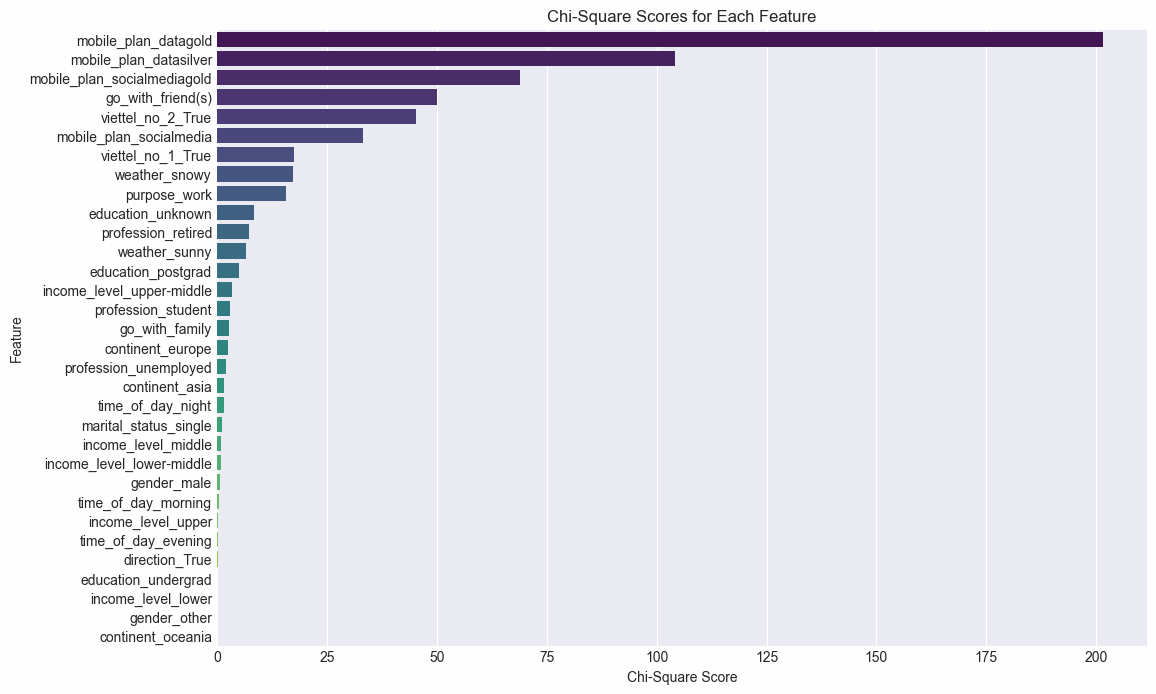

In [66]:
# Sử dụng SelectKBest với chi-square
selector = SelectKBest(score_func=chi2, k='all')  # 'all' để giữ tất cả các đặc trưng cho việc đánh giá
X_selected = selector.fit_transform(X_processed.drop(axis=1, columns=continuous_cols), y)

# Lấy ra các scores và p-values
scores = selector.scores_
p_values = selector.pvalues_

# Tạo DataFrame kết quả
feature_scores_chi2 = pd.DataFrame({'Feature': X_processed.drop(axis=1, columns=continuous_cols).columns, 'Score': scores, 'p-Value': p_values})
feature_scores_chi2 = feature_scores_chi2.sort_values(by='Score', ascending=False)

# Biểu diễn biểu đồ
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores_chi2, palette='viridis')
plt.title('Chi-Square Scores for Each Feature')
plt.xlabel('Chi-Square Score')
plt.ylabel('Feature')
plt.show()

## ANOVA


In [67]:
from sklearn.feature_selection import f_classif

# Usse SelectKBest to find the best features
selector = SelectKBest(score_func=f_classif, k='all')  # 'all' to keep all features
X_selected = selector.fit_transform(X_processed[continuous_cols], y)

# Get the scores and p-values
scores = selector.scores_
p_values = selector.pvalues_

# Create a DataFrame with the feature scores
feature_scores_anova = pd.DataFrame({'Feature': X_processed[continuous_cols].columns, 'Score': scores, 'p-Value': p_values})
feature_scores_anova = feature_scores_anova.sort_values(by='Score', ascending=False)
feature_scores_anova

,Feature,Score,p-Value
5,use_2GB_to_4GB,13.514070,0.000237
1,fb_freq,12.049509,0.000519
4,use_less_than_2GB,11.752842,0.000608
8,score,6.145675,0.013177
2,yt_freq,4.951120,0.026079
3,insta_freq,4.020838,0.044948
0,age,3.945524,0.047003
7,children,3.657492,0.055825
6,income_dollar,0.059310,0.807591


- Ý nghĩa của F-value: Giá trị F cao chỉ ra rằng đặc trưng đó có thể phân biệt tốt giữa các lớp của biến mục tiêu.
- p-value: p-value đi kèm cho biết mức độ xác suất của việc quan sát thấy giá trị F này trong trường hợp giả thuyết không (null hypothesis) là đúng. Giá trị p-value nhỏ cho thấy sự khác biệt quan sát được là có ý nghĩa thống kê và không phải do ngẫu nhiên.


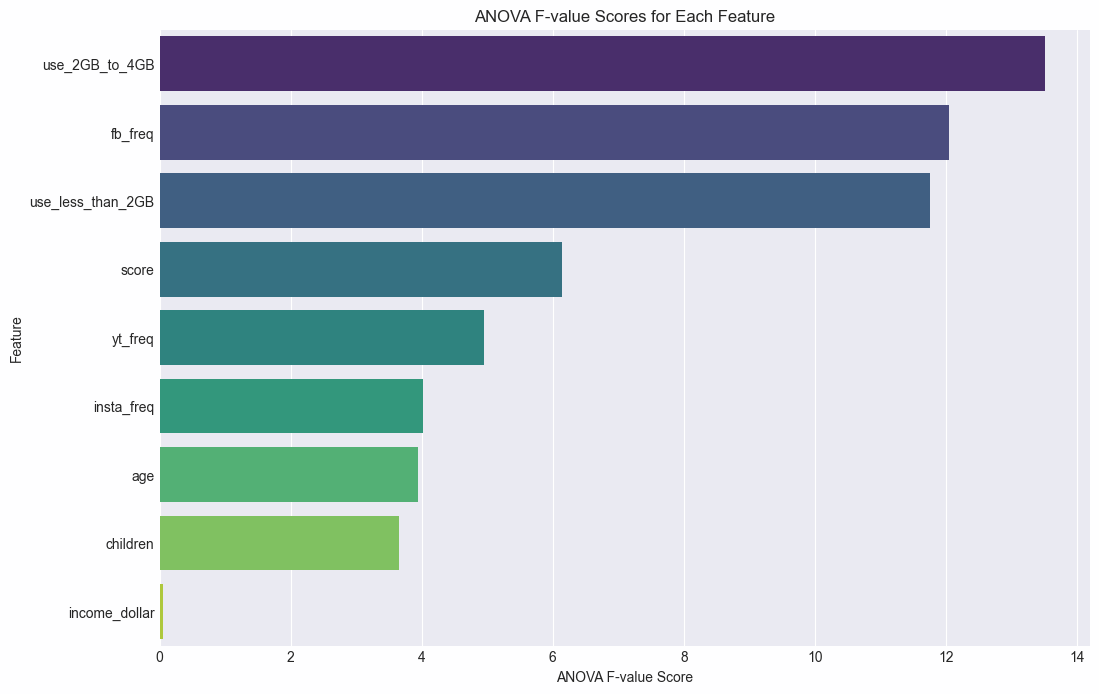

In [68]:
# Biểu diễn biểu đồ
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores_anova, palette='viridis')
plt.title('ANOVA F-value Scores for Each Feature')
plt.xlabel('ANOVA F-value Score')
plt.ylabel('Feature')
plt.show()

# Feature engineering


## Social media


In [69]:
def sm_ext(df, threshold):
  sm_avg_usage = df[['fb_freq', 'yt_freq', 'insta_freq']].apply(lambda x: x.sum(), axis=1)
  df['sm_ext'] = sm_avg_usage.apply(lambda x: True if x > threshold else False)

sm_ext(model_input_1, 10)
sm_ext(model_test, 10)

## use_less_than_2GB and use_2GB_to_4GB


In [70]:
def usage_ext(df):
  usage = ['use_less_than_2GB', 'use_2GB_to_4GB']
  for x in usage:
    range = 1.5
    IQR = df[x].quantile(0.75) - df[x].quantile(0.25)
    upper_bound = df[x].quantile(0.75) + (IQR * range)

    df[f"{x}_ext"] = df[x].apply(lambda y: True if y > upper_bound else False)

usage_ext(model_input_1)
usage_ext(model_test)

## education


In [71]:
def education_abn(df):
  df['education_abn'] = df['education'].apply(lambda x: True if x == 'unknown' else False)

education_abn(model_input_1)
education_abn(model_test)

## score


In [72]:
def score_ext(df):
  range = 1.5
  IQR = df['score'].quantile(0.75) - df['score'].quantile(0.25)
  upper_bound = df['score'].quantile(0.75) + (IQR * range)

  df['score_ext'] = df['score'].apply(lambda y: True if y > upper_bound else False)

score_ext(model_input_1)
score_ext(model_test)

## Remove low important features


In [73]:
def remove_low_important(df, feature_list):
  df = df.drop(axis=1, columns=feature_list)
  return df

In [74]:
model_input_1 = remove_low_important(model_input_1, ['gender'])
model_test = remove_low_important(model_test, ['gender'])

## Imbalance sampling


<function matplotlib.pyplot.show(close=None, block=None)>

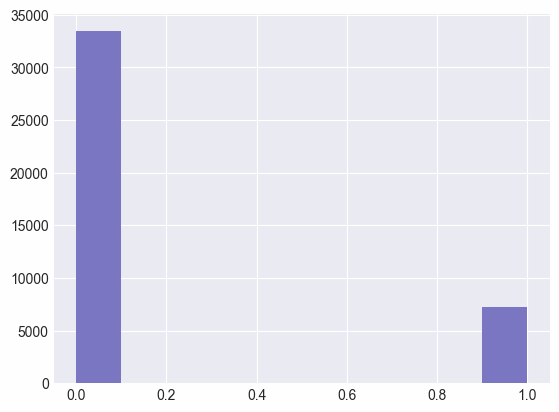

In [75]:
plt.hist(model_input_1['accept'].astype(int))
plt.show

In [76]:
def resampling(X, y):
  # One-hot encode categorical features
  X_encoded = pd.get_dummies(X)
  # Apply the SMOTE algorithm to balance the dataset
  sm = SMOTE(random_state=seed)
  X_res, y_res = sm.fit_resample(X_encoded, y)
  X_res = pd.DataFrame(X_res, columns=X_encoded.columns)  # Retain column names
  y_res = pd.Series(y_res, name='accept')  # Ensure y_res is a pandas Series
  return X_res, y_res

# Model building


In [77]:
import joblib
from joblib import dump, load
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

In [78]:
# Initialize classifiers
models = {
    'KNeighbors Classifier': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=seed),
    'Random Forest Classifier': RandomForestClassifier(random_state=seed),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=seed),
    'AdaBoost Classifier': AdaBoostClassifier(random_state=seed),
    'XGBoost Classifier': XGBClassifier(random_state=seed)
}
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

## Single model

### Function

#### Train


In [79]:
def train_single_model(X, y, models, kf, approach, param_grid=None, low_fi_list=None, random_state=None):
    # Encode categorical columns
    cat_columns = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    num_columns = X.select_dtypes(include=np.number).columns.tolist()

    # Initialize preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_columns),
            ('cat', OneHotEncoder(), cat_columns)
        ],
        remainder='passthrough'
    )

    # Initialize results
    results = []
    model_results = []
    best_model = None
    best_f1_score = 0
    best_params = None  # Variable to store best parameters

    # Train each model
    for name, model in models.items():
        print(f"Training {name}...")
        accuracy_cv_scores = []
        hamming_cv_losses = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        # Train the model using KFold
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Initialize pipeline
            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', model)
            ])

            if param_grid:
                grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1_weighted', cv=kf, n_jobs=-1)
                grid_search.fit(X_train, y_train)
                best_estimator = grid_search.best_estimator_
                y_pred = best_estimator.predict(X_test)
            else:
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)

            # Metrics
            acc = accuracy_score(y_test, y_pred)
            hamming = hamming_loss(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            accuracy_cv_scores.append(acc)
            hamming_cv_losses.append(hamming)
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)

        # Calculate the mean of each metric
        mean_accuracy = np.mean(accuracy_cv_scores)
        mean_hamming_loss = np.mean(hamming_cv_losses)
        mean_precision = np.mean(precision_scores)
        mean_recall = np.mean(recall_scores)
        mean_f1_score = np.mean(f1_scores)

        # Save model results
        model_results.append({
            'Model': name,
            'Mean Accuracy': mean_accuracy,
            'Mean Hamming Loss': mean_hamming_loss,
            'Mean Precision': mean_precision,
            'Mean Recall': mean_recall,
            'Mean F1-score': mean_f1_score
        })

        # Update the best model if current model is better based on F1-score
        if mean_f1_score > best_f1_score:
            best_f1_score = mean_f1_score
            best_model = grid_search.best_estimator_ if param_grid else pipeline
            best_params = grid_search.best_params_ if param_grid else None  # Save best parameters

    # Save the best model for the current label
    joblib.dump(best_model, f'best_model_{approach}.pkl')

    # Print best parameters if GridSearchCV was used
    if best_params:
        print(f"Best parameters for {name}: {best_params}")

    # Convert results to DataFrame and sort by Mean F1-score
    model_results_df = pd.DataFrame(model_results)
    model_results_df = model_results_df.sort_values(by='Mean F1-score', ascending=False)

    return model_results_df, best_params

#### Test


In [80]:
def test_single_model(X, y, model_to_test):
  # Load best model from file
  model = joblib.load(model_to_test)

  # Predict on the test set
  y_pred = model.predict(X)

  # Ví dụ tính toán các độ đo
  accuracy_test = accuracy_score(y, y_pred)
  hamming_loss_test = hamming_loss(y, y_pred)
  precision_test = precision_score(y, y_pred, average='weighted')
  recall_test = recall_score(y, y_pred, average='weighted')
  f1_test = f1_score(y, y_pred, average='weighted')

  # Tạo DataFrame chứa các độ đo
  metrics = {
    'Metric': ['F1-score', 'Accuracy', 'Hamming Loss', 'Precision', 'Recall'],
    'Value': [f1_test, accuracy_test, hamming_loss_test, precision_test, recall_test]}
  metrics_df = pd.DataFrame(metrics)
  return metrics_df

### Test set


In [81]:
# Split data into X_test and y_test
X_test = model_test.drop(axis=1, columns=['accept'])
X_test = pd.get_dummies(X_test)
y_test = model_test['accept']

### Approach

#### Approach 1

Nguyên vẹn


In [82]:
# model_input_1 = remove_low_important(model_input_1, ['gender'])

# Split data into X and y
X1 = model_input_1.drop(axis=1, columns=['accept'])
y1 = model_input_1['accept']

X1_res, y1_res = resampling(X1, y1)

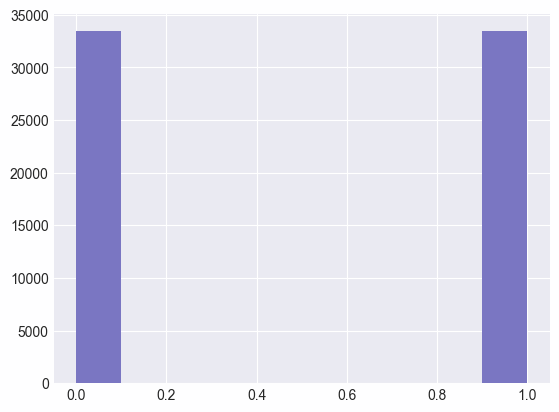

In [83]:
plt.hist(y1_res.astype(int))
plt.show()

In [84]:
ap1_result_df, _ = train_single_model(X1_res, y1_res, models, kf, 'ap1_extension', param_grid=None, random_state=seed)

Training KNeighbors Classifier...
Training Logistic Regression...
Training Random Forest Classifier...
Training Gradient Boosting Classifier...
Training AdaBoost Classifier...
Training XGBoost Classifier...


In [85]:
ap1_result_df

,Model,Mean Accuracy,Mean Hamming Loss,Mean Precision,Mean Recall,Mean F1-score
2,Random Forest Classifier,0.883323,0.116677,0.887467,0.883323,0.883010
5,XGBoost Classifier,0.881200,0.118800,0.893159,0.881200,0.880290
1,Logistic Regression,0.868897,0.131103,0.896138,0.868897,0.866603
3,Gradient Boosting Classifier,0.866430,0.133570,0.894487,0.866430,0.864012
4,AdaBoost Classifier,0.864726,0.135274,0.892397,0.864726,0.862299
0,KNeighbors Classifier,0.857551,0.142449,0.858665,0.857551,0.857445


In [86]:
ap1_test = test_single_model(X_test, y_test, 'best_model_ap1_extension.pkl')
ap1_test

,Metric,Value
0,F1-score,0.453397
1,Accuracy,0.581320
2,Hamming Loss,0.418680
3,Precision,0.580359
4,Recall,0.581320


#### Approach 2

Dup 5


In [87]:
df_mobile_plan = pd.DataFrame(mobile_plans, columns=['mobile_plan'])
temp_df = eda_df.merge(df_mobile_plan, how='cross')

# Merge the dataframes
model_input_2 = temp_df.merge(mobile_plan_user, on=['id', 'mobile_plan'], how='left')
model_input_2 = model_input_2.fillna(False)
model_input_2 = model_input_2.drop_duplicates(subset=['id', 'mobile_plan'])

# drop columns
model_input_2 = model_input_2.drop(axis=1, columns=to_drop)

sm_ext(model_input_2, 10)
usage_ext(model_input_2)
education_abn(model_input_2)
score_ext(model_input_2)
model_input_2 = remove_low_important(model_input_2, ['gender'])

In [88]:
# Split data into X and y
X2 = model_input_2.drop(axis=1, columns=['accept'])
y2 = model_input_2['accept']

X2_res, y2_res = resampling(X2, y2)

In [89]:
ap2_result_df, _ = train_single_model(X2_res, y2_res, models, kf, 'ap2_extension', param_grid=None, random_state=seed)

Training KNeighbors Classifier...
Training Logistic Regression...
Training Random Forest Classifier...
Training Gradient Boosting Classifier...
Training AdaBoost Classifier...
Training XGBoost Classifier...


In [90]:
ap2_result_df

,Model,Mean Accuracy,Mean Hamming Loss,Mean Precision,Mean Recall,Mean F1-score
1,Logistic Regression,0.938919,0.061081,0.945574,0.938919,0.938691
2,Random Forest Classifier,0.938328,0.061672,0.943841,0.938328,0.938137
5,XGBoost Classifier,0.937854,0.062146,0.943850,0.937854,0.937644
3,Gradient Boosting Classifier,0.935247,0.064753,0.942676,0.935247,0.934975
4,AdaBoost Classifier,0.934211,0.065789,0.941864,0.934211,0.933925
0,KNeighbors Classifier,0.916518,0.083482,0.918448,0.916518,0.916422


In [91]:
ap2_test = test_single_model(X_test, y_test, 'best_model_ap2_extension.pkl')
ap2_test

,Metric,Value
0,F1-score,0.421621
1,Accuracy,0.576490
2,Hamming Loss,0.423510
3,Precision,0.332340
4,Recall,0.576490


#### Approach 3

max accept


In [92]:
ap_acp_max = mobile_plan_user.groupby(['id', 'mobile_plan'], as_index=False)['accept'].max()
model_input_3 = eda_df.merge(ap_acp_max, on="id", how="left")
# drop columns
model_input_3 = model_input_3.drop(axis=1, columns=to_drop)

sm_ext(model_input_3, 10)
usage_ext(model_input_3)
education_abn(model_input_3)
score_ext(model_input_3)
model_input_3 = remove_low_important(model_input_3, ['gender'])

In [93]:
# Split data into X and y
X3 = model_input_3.drop(axis=1, columns=['accept'])
y3 = model_input_3['accept']

X3_res, y3_res = resampling(X3, y3)
ap3_resutl_df, _ = train_single_model(X3_res, y3_res, models, kf, 'ap3_extension', param_grid=None, random_state=seed)

Training KNeighbors Classifier...
Training Logistic Regression...
Training Random Forest Classifier...
Training Gradient Boosting Classifier...
Training AdaBoost Classifier...
Training XGBoost Classifier...


In [94]:
ap3_resutl_df

,Model,Mean Accuracy,Mean Hamming Loss,Mean Precision,Mean Recall,Mean F1-score
1,Logistic Regression,0.871769,0.128231,0.897960,0.871769,0.869621
2,Random Forest Classifier,0.869431,0.130569,0.885290,0.869431,0.868075
3,Gradient Boosting Classifier,0.869851,0.130149,0.896591,0.869851,0.867618
5,XGBoost Classifier,0.864757,0.135243,0.879962,0.864757,0.863387
4,AdaBoost Classifier,0.865776,0.134224,0.893386,0.865776,0.863374
0,KNeighbors Classifier,0.828739,0.171261,0.831144,0.828739,0.828429


In [95]:
ap3_test = test_single_model(X_test, y_test, 'best_model_ap3_extension.pkl')
ap3_test

,Metric,Value
0,F1-score,0.421621
1,Accuracy,0.576490
2,Hamming Loss,0.423510
3,Precision,0.332340
4,Recall,0.576490


### Model comparision


In [96]:
# Concatenate the train results
single_model_train_results = [
    ap1_result_df,
    ap2_result_df,
    ap3_resutl_df,
    ]

i = 1
while i < len(single_model_train_results):
  for x in single_model_train_results:
    x['Approach'] = f'AP{i}'
    i += 1

#### Model for each approach


In [97]:
ap_model = pd.DataFrame()
dfs = []

# Iterate through single_model_train_results
for x in single_model_train_results:
    # Append the first row of each DataFrame x to the list
    dfs.append(x.head(1))

ap_model = pd.concat(dfs, axis=0)
ap_model = ap_model[['Approach', 'Model', 'Mean Accuracy', 'Mean Hamming Loss', 'Mean Precision', 'Mean Recall', 'Mean F1-score']]
ap_model = ap_model.reset_index(drop=True)
ap_model

,Approach,Model,Mean Accuracy,Mean Hamming Loss,Mean Precision,Mean Recall,Mean F1-score
0,AP1,Random Forest Classifier,0.883323,0.116677,0.887467,0.883323,0.883010
1,AP2,Logistic Regression,0.938919,0.061081,0.945574,0.938919,0.938691
2,AP3,Logistic Regression,0.871769,0.128231,0.897960,0.871769,0.869621


#### Model performance


In [98]:
single_model_performance = [
  ap1_test,
  ap2_test,
  ap3_test
]

i = 1
while i < len(single_model_performance):
  for x in single_model_performance:
    x['Approach'] = f'AP{i}'
    i += 1

ap_model_performance = pd.DataFrame()
dfs = []

for x in single_model_performance:
  dfs.append(x.pivot_table(columns='Metric', values='Value', index='Approach'))
ap_model_performance = pd.concat(dfs, axis=0)
ap_model_performance

Metric,Accuracy,F1-score,Hamming Loss,Precision,Recall
Approach,,,,,
AP1,0.58132,0.453397,0.41868,0.580359,0.58132
AP2,0.57649,0.421621,0.42351,0.332340,0.57649
AP3,0.57649,0.421621,0.42351,0.332340,0.57649


## Multi model


In [99]:
df_mobile_plan = pd.DataFrame(mobile_plans, columns=['mobile_plan'])
temp_df = eda_df.merge(df_mobile_plan, how='cross')

# Merge the dataframes
multi_model_input = temp_df.merge(mobile_plan_user, on=['id', 'mobile_plan'], how='left')
multi_model_input = multi_model_input.fillna(False)
multi_model_input = multi_model_input.drop_duplicates(subset=['id', 'mobile_plan'])

# drop columns
multi_model_input = multi_model_input.drop(axis=1, columns=to_drop)

sm_ext(multi_model_input, 10)
usage_ext(multi_model_input)
education_abn(multi_model_input)
score_ext(multi_model_input)
multi_model_input = remove_low_important(multi_model_input, ['gender'])

In [100]:
datasilver = multi_model_input[multi_model_input['mobile_plan'] == 'datasilver']
socialmediagold = multi_model_input[multi_model_input['mobile_plan'] == 'socialmediagold']
socialmedia = multi_model_input[multi_model_input['mobile_plan'] == 'socialmedia']
datacall = multi_model_input[multi_model_input['mobile_plan'] == 'datacall']
datagold = multi_model_input[multi_model_input['mobile_plan'] == 'datagold']

mobile_plans_df = [datasilver, socialmediagold, socialmedia, datacall, datagold]

### Function

#### Train


In [101]:
def train_multi_model(df_list, models, kf, approach, param_grid=None, random_state=None):
    # Initialize overall results storage
    overall_results = []

    for df in df_list:
        mobile_plan = df['mobile_plan'].unique()[0]
        print(f'Training for mobile plan: {mobile_plan}')

        X = df.drop(columns=['accept', 'mobile_plan'])
        y = df['accept']

        # Resampling
        X_res, y_res = resampling(X, y)

        # Encode categorical columns
        cat_columns = X_res.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
        num_columns = X_res.select_dtypes(include=np.number).columns.tolist()

        # Initialize preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), num_columns),
                ('cat', OneHotEncoder(), cat_columns)
            ],
            remainder='passthrough'
        )

        best_model = None
        best_f1_score = 0
        best_params = None

        # Train each model
        for name, model in models.items():
            print(f"Training {name}...")

            accuracy_cv_scores = []
            hamming_cv_losses = []
            precision_scores = []
            recall_scores = []
            f1_scores = []

            # Train the model using KFold
            for train_index, test_index in kf.split(X_res):
                X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
                y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]

                # Initialize pipeline
                pipeline = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('classifier', model)
                ])

                if param_grid:
                    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1_weighted', cv=kf, n_jobs=-1)
                    grid_search.fit(X_train, y_train)
                    best_estimator = grid_search.best_estimator_
                    y_pred = best_estimator.predict(X_test)
                else:
                    pipeline.fit(X_train, y_train)
                    y_pred = pipeline.predict(X_test)

                # Metrics
                acc = accuracy_score(y_test, y_pred)
                hamming = hamming_loss(y_test, y_pred)
                precision = precision_score(y_test, y_pred, average='weighted')
                recall = recall_score(y_test, y_pred, average='weighted')
                f1 = f1_score(y_test, y_pred, average='weighted')

                accuracy_cv_scores.append(acc)
                hamming_cv_losses.append(hamming)
                precision_scores.append(precision)
                recall_scores.append(recall)
                f1_scores.append(f1)

            # Calculate the mean of each metric
            mean_accuracy = np.mean(accuracy_cv_scores)
            mean_hamming_loss = np.mean(hamming_cv_losses)
            mean_precision = np.mean(precision_scores)
            mean_recall = np.mean(recall_scores)
            mean_f1_score = np.mean(f1_scores)

            # Save model results
            model_result = {
                'Mobile Plan': mobile_plan,
                'Model': name,
                'Mean Accuracy': mean_accuracy,
                'Mean Hamming Loss': mean_hamming_loss,
                'Mean Precision': mean_precision,
                'Mean Recall': mean_recall,
                'Mean F1-score': mean_f1_score
            }
            overall_results.append(model_result)

            # Update the best model if current model is better based on F1-score
            if mean_f1_score > best_f1_score:
                best_f1_score = mean_f1_score
                best_model = grid_search.best_estimator_ if param_grid else pipeline
                best_params = grid_search.best_params_ if param_grid else None

        print('*' * 50)
        # Save the best model for the current label
        joblib.dump(best_model, f'best_model_{mobile_plan}_{approach}.pkl')

        # Print best parameters if GridSearchCV was used
        if best_params:
            print(f"Best parameters for {mobile_plan} with model {name}: {best_params}")

    # Convert results to DataFrame and sort by Mean F1-score
    overall_results_df = pd.DataFrame(overall_results)
    overall_results_df = overall_results_df.sort_values(by='Mean F1-score', ascending=False)

    return overall_results_df, best_params

### Train


In [102]:
ap4_resutl_df, _ = train_multi_model(mobile_plans_df, models, kf, 'ap4_extension', param_grid=None, random_state=seed)

Training for mobile plan: datasilver
Training KNeighbors Classifier...
Training Logistic Regression...
Training Random Forest Classifier...
Training Gradient Boosting Classifier...
Training AdaBoost Classifier...
Training XGBoost Classifier...
**************************************************
Training for mobile plan: socialmediagold
Training KNeighbors Classifier...
Training Logistic Regression...
Training Random Forest Classifier...
Training Gradient Boosting Classifier...
Training AdaBoost Classifier...
Training XGBoost Classifier...
**************************************************
Training for mobile plan: socialmedia
Training KNeighbors Classifier...
Training Logistic Regression...
Training Random Forest Classifier...
Training Gradient Boosting Classifier...
Training AdaBoost Classifier...
Training XGBoost Classifier...
**************************************************
Training for mobile plan: datacall
Training KNeighbors Classifier...
Training Logistic Regression...
Training

In [103]:
ap4_resutl_df.groupby('Mobile Plan').max('Mean F1-score')

,Mean Accuracy,Mean Hamming Loss,Mean Precision,Mean Recall,Mean F1-score
Mobile Plan,,,,,
datacall,0.961034,0.062308,0.963483,0.961034,0.960981
datagold,0.966725,0.053065,0.968520,0.966725,0.966692
datasilver,0.917973,0.108464,0.929561,0.917973,0.917420
socialmedia,0.915853,0.110418,0.927967,0.915853,0.915251
socialmediagold,0.926564,0.100802,0.935974,0.926564,0.926163


In [104]:
# Define the test sets for each mobile plan
datasilver_test = model_test[model_test['mobile_plan'] == 'datasilver'].drop(columns='mobile_plan')
socialmediagold_test = model_test[model_test['mobile_plan'] == 'socialmediagold'].drop(columns='mobile_plan')
socialmedia_test = model_test[model_test['mobile_plan'] == 'socialmedia'].drop(columns='mobile_plan')
datacall_test = model_test[model_test['mobile_plan'] == 'datacall'].drop(columns='mobile_plan')
datagold_test = model_test[model_test['mobile_plan'] == 'datagold'].drop(columns='mobile_plan')

# Function to split data into X and y, and apply one-hot encoding
def prepare_data(df):
    X = df.drop(columns=['accept'])
    y = df['accept']
    return X, y

# Prepare the test datasets for each mobile plan
X_datasilver_test, y_datasilver_test = prepare_data(datasilver_test)
X_datasilver_test, y_datasilver_test = resampling(X_datasilver_test, y_datasilver_test)

X_socialmediagold_test, y_socialmediagold_test = prepare_data(socialmediagold_test)
X_socialmediagold_test, y_socialmediagold_test = resampling(X_socialmediagold_test, y_socialmediagold_test)

X_socialmedia_test, y_socialmedia_test = prepare_data(socialmedia_test)
X_socialmedia_test, y_socialmedia_test = resampling(X_socialmedia_test, y_socialmedia_test)

X_datacall_test, y_datacall_test = prepare_data(datacall_test)
X_datacall_test, y_datacall_test = resampling(X_datacall_test, y_datacall_test)

X_datagold_test, y_datagold_test = prepare_data(datagold_test)
X_datagold_test, y_datagold_test = resampling(X_datagold_test, y_datagold_test)


In [105]:
# Define a function to test a single model
def test_multi_model(X_test, y_test, model_path):
    try:
        # Load the model
        model = joblib.load(model_path)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        hamming = hamming_loss(y_test, y_pred)
        
        # Return results as a dictionary
        return {
            'Model': model_path,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'Hamming Loss': hamming
        }
    except Exception as e:
        print(f"Error with model {model_path}: {e}")
        return None

# Test datasets for each mobile plan
test_datasets = {
    'datasilver': (X_datasilver_test, y_datasilver_test),
    'socialmediagold': (X_socialmediagold_test, y_socialmediagold_test),
    'socialmedia': (X_socialmedia_test, y_socialmedia_test),
    'datacall': (X_datacall_test, y_datacall_test),
    'datagold': (X_datagold_test, y_datagold_test)
}

# List of model paths corresponding to the test datasets
model_paths = [
    'best_model_datasilver_ap4_extension.pkl', 
    'best_model_socialmediagold_ap4_extension.pkl', 
    'best_model_socialmedia_ap4_extension.pkl', 
    'best_model_datacall_ap4_extension.pkl', 
    'best_model_datagold_ap4_extension.pkl'
]

# Initialize results list
results = []

# Iterate over each test dataset and corresponding model
for (mobile_plan, (X_test, y_test)), model_path in zip(test_datasets.items(), model_paths):
    result = test_multi_model(X_test, y_test, model_path)
    if result is not None:
        result['Mobile Plan'] = mobile_plan  # Add mobile plan to the result
        results.append(result)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Reorder columns for better readability
results_df = results_df[['Mobile Plan', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Hamming Loss']]

# Display the results
results_df

,Mobile Plan,Accuracy,Precision,Recall,F1-score,Hamming Loss
0,datasilver,0.486395,0.246552,0.486395,0.327231,0.513605
1,socialmediagold,0.422535,0.229008,0.422535,0.297030,0.577465
2,socialmedia,0.642857,0.791667,0.642857,0.590643,0.357143
3,datacall,0.801325,0.853475,0.801325,0.793716,0.198675
4,datagold,0.752874,0.834615,0.752874,0.736800,0.247126


In [106]:
def feature_importances_show(X, model_file_path):
  # Load the best model and plot feature importance
  best_model_file = model_file_path
  best_model = joblib.load(best_model_file)

  # Get feature names after preprocessing
  preprocessor = best_model.named_steps['preprocessor']
  object_columns = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
  encoded_feature_names = preprocessor.named_transformers_['cat'].categories_
  feature_names_encoded = [f"{col}={val}" for col, vals in zip(object_columns, encoded_feature_names) for val in vals]
  feature_names = np.concatenate((X.columns.difference(object_columns), feature_names_encoded))

  # Check if the model supports feature importances
  if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
      feature_importances = best_model.named_steps['classifier'].feature_importances_

      # Create DataFrame to store and display feature importances
      importance_df = pd.DataFrame({
          'Feature': feature_names,
          'Importance': feature_importances
      })

      # Sort by importance descending
      importance_df = importance_df.sort_values(by='Importance', ascending=False)

      # Plot feature importances
      plt.figure(figsize=(10, 8))
      plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
      plt.xlabel('Importance')
      plt.ylabel('Feature')
      plt.title('Feature Importance')
      plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
      plt.tight_layout(pad=0.01)  # Increase spacing between bars
      plt.show()

  else:
      print("The XGBoost model does not support computing feature importances.")
  
  return importance_df

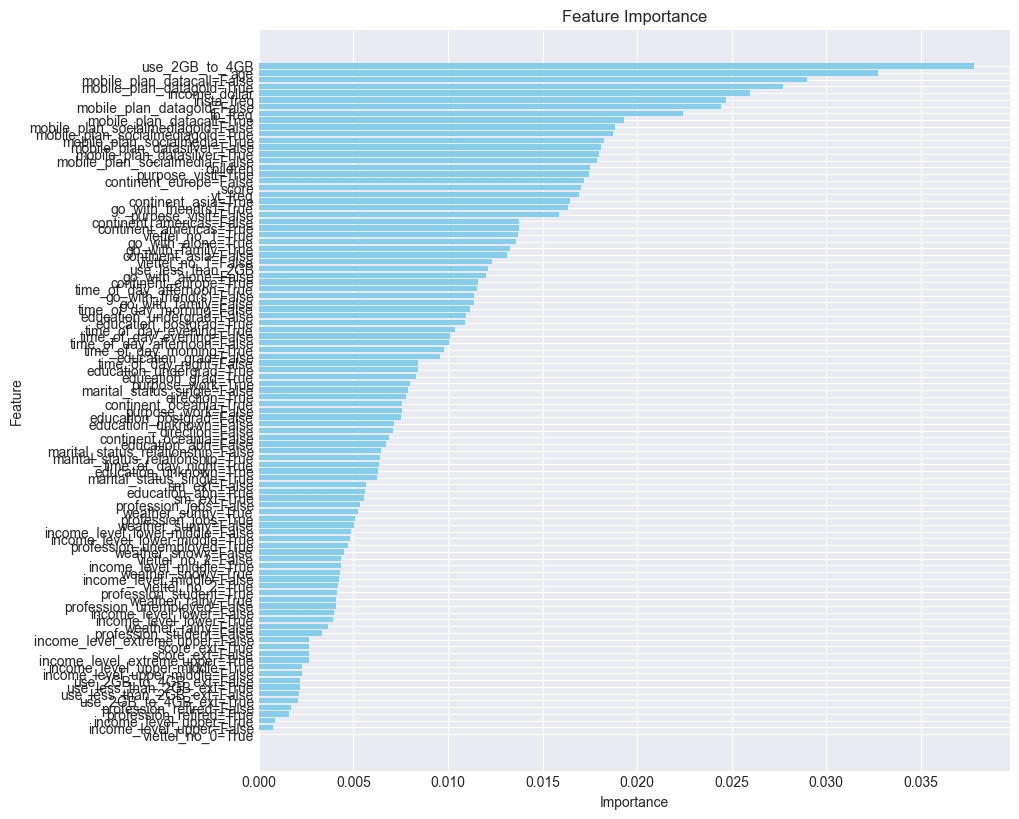

In [107]:
FI_ap2 = feature_importances_show(X2_res, 'best_model_ap2.pkl')
low_FI_ap2 = FI_ap2.query('Importance < 0.005').Feature.unique()
low_FI_columns = list(set([item.split('=')[0] if '=' in item else item for item in low_FI_ap2]))

In [108]:
ap2_chosen_model = {'XGBoost Classifier': XGBClassifier(random_state=seed)}

In [109]:
ap2_drop_low_FI, _ = train_single_model(X2_res.drop(axis=1, columns=low_FI_columns), y2_res, ap2_chosen_model, kf, 'ap2_drop_low_FI')
ap2_drop_low_FI

Training XGBoost Classifier...


,Model,Mean Accuracy,Mean Hamming Loss,Mean Precision,Mean Recall,Mean F1-score
0,XGBoost Classifier,0.937243,0.062757,0.94334,0.937243,0.937028


In [ ]:
ap2_drop_low_FI_test = test_single_model(X_test, y_test, 'best_model_ap2_drop_low_FI.pkl')
ap2_drop_low_FI_test